In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio, rasterio.plot
import shapely as shp
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import pytorch_lightning as pl
import pickle
# import tabulate

from geocube.api.core import make_geocube
# import segmentation_models_pytorch as smp
lcv.set_fontsize(10)
path_dict = loadpaths.loadpaths()

Font size is set to 10


In [23]:
path_mapping_dict =  '../content/label_mapping_dicts/label_mapping_dict__identity__2023-04-20-1541.pkl'
# path_mapping_dict = '../content/label_mapping_dicts/label_mapping_dict__all_relevant_subclasses__2023-04-20-1540.pkl'
with open(path_mapping_dict, 'rb') as f:
    label_mapping_dict = pickle.load(f)

dict_colour = {'train': 'grey', 'test': 'k',
               'C': '#0e8212',
                'D': '#a33b1a',
               'E': '#465E85'}
dict_labels_full = {'C': 'C - Woodlands',
                    'D': 'D - Moorlands',
                    'E': 'E - Grasslands'}
roman_numerics = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x',
                  'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xvii', 'xviii', 'xix', 'xx']

In [10]:
folder_model = '/home/thijs/Google Drive/peak district/models/2024-03-22/saved_cnn_models'
# file_name = 'main_LCU_2023-04-24-1259_FULL.data'
file_name = 'main_LCU_2023-04-24-1259.pth'
LCU = lcm.load_model_auto(folder=folder_model, filename=file_name)

cross_entropy loss is used.


In [11]:
dir_test_im_patches = path_dict['im_patches']
# dir_test_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/images_detailed_annotation/'
mask_suffix_test_ds = '_lc_2022_detailed_mask.npy'
       
test_ds_main = lcm.DataSetPatches(im_dir=dir_test_im_patches, mask_dir=None, 
                            mask_suffix=mask_suffix_test_ds, mask_dir_name='masks_python_all',
                            preprocessing_func=LCU.preprocessing_func, 
                            shuffle_order_patches=False, relabel_masks=True,
                            subsample_patches=False,
                            # list_tile_patches_use=tile_patch_test,
                            path_mapping_dict=path_mapping_dict)
test_ds_main.remove_no_class_patches()

No mask directory provided. Will use masks_python_all/ in image parent directory instead.
Patches sorted by tile/patch order
Loaded 1027 patches
Loaded label_mapping_dict__identity__2023-04-20-1541.pkl to map labels


  0%|          | 0/1027 [00:00<?, ?it/s]

100%|██████████| 1027/1027 [00:14<00:00, 68.82it/s]

Removed 0 patches with no class


In [12]:
test_ds_main.class_name_list

['NO CLASS',
 'Broadleaved High Forest',
 'Coniferous High Forest',
 'Mixed High Forest',
 'Scrub',
 'Scrub Pasture',
 'Woodland/Scrub Edge',
 'Clear Felled/New Plantings in Forest Areas',
 'Upland Heath',
 'Upland Heath Blanket Bog',
 'Upland Grass Moor',
 'Blanket Peat Grass Moor',
 'Bracken',
 'Unenclosed Lowland Rough Grassland',
 'Unenclosed Lowland Heath',
 'Upland Heath/Grass Mosaic',
 'Upland Heath/Bracken Mosaic',
 'Upland Heath/Blanket Peat Mosaic',
 'Eroded Bare Peat',
 'Eroded Bare Mineral Soil',
 'Coastal Heath',
 'Cultivated Land',
 'Improved Pasture',
 'Rough Pasture',
 'Open Water, Coastal',
 'Open Water, Inland',
 'Wetland, Peat Bog',
 'Wetland, Freshwater Marsh',
 'Wetland, Saltmarsh',
 'Wetland, Wet Grassland and Rush Pasture',
 'Inland Bare Rock',
 'Coastal Bare Rock',
 'Coastal Dunes',
 'Coastal Sand Beach',
 'Coastal Shingle Beach',
 'Coastal Mudflats',
 'Urban',
 'Major Transport Routes',
 'Minor Transport Routes',
 'Urban Greenspace',
 'Quarries and Mineral Work

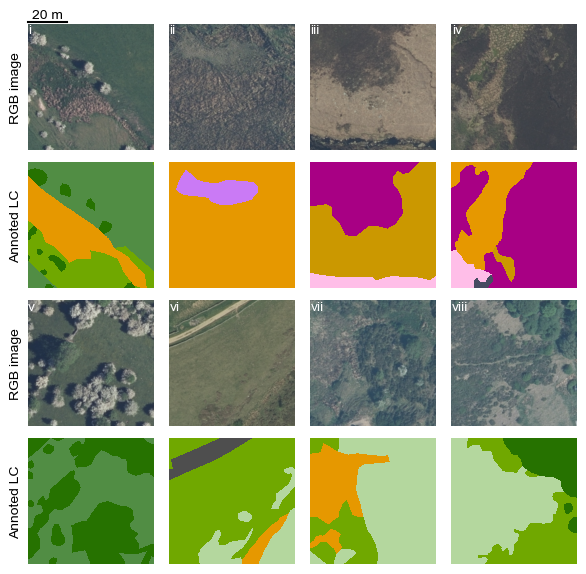

In [72]:
save_fig = True
add_cbar = False
add_title = False
add_scalebar = True

# names_examples = ['SK0956_patch081', 
#                   'SK0879_patch034',
#                   'SK0988_patch028', 
#                     'SK2096_patch129',
#                     'SK0752_patch049']
names_examples = ['SK0752_patch049', 'SK0464_patch200', 'SK2096_patch148',
                'SK1798_patch031', 'SK0852_patch202', 'SK0684_patch215',
                'SK1778_patch070', 'SK0879_patch008']

inds_examples = []
for x in names_examples:
    # if x not in test_ds_main.df_patches['patch_name']:
    #     print(f'WARNING: {x} does not exist. skipping')
    #     continue
    bool_arr_tmp = np.where(test_ds_main.df_patches['patch_name'] == x)[0]
    if np.sum(bool_arr_tmp) == 0:
        print(f'WARNING: {x} does not exist. skipping')
        continue
    inds_examples.append(int(bool_arr_tmp[0]))
# inds_examples = [10, 26, 39, 40, 77]  # either specify the indices or the names
# inds_examples = [436, 411, 491, 904, 341]

# inds_examples = np.random.choice(len(test_ds_main), 12, replace=False)
# inds_examples = [int(x) for x in inds_examples]
# names_examples = [test_ds_main.df_patches['patch_name'].iloc[x] for x in inds_examples]

### Create fig:
max_cols = 4

n_examples = len(inds_examples)
n_cols = np.minimum(n_examples, max_cols)
n_rows = int(2 * np.ceil(n_examples / max_cols))
fig = plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5), constrained_layout=False)

gs_ims = fig.add_gridspec(n_rows, n_cols, wspace=0.05, hspace=0.1, left=0.02, right=0.75 if add_cbar else 0.95, 
                          top=0.95, bottom=0.05)
if add_cbar:
    gs_cbar = fig.add_gridspec(1, 1, left=0.9, right=0.92, top=0.55, bottom=0.05)
    ax_cbar = fig.add_subplot(gs_cbar[0])
else:
    ax_cbar = None

ax_ims = []
ax_lcs = []
row_ind = 0
for i in range(n_examples):
    if i % max_cols == 0 and i > 0:
        row_ind += 2
    col_ind = i % max_cols
    ax_ims.append(fig.add_subplot(gs_ims[row_ind, col_ind]))
    ax_lcs.append(fig.add_subplot(gs_ims[row_ind + 1, col_ind]))
assert len(inds_examples) == n_examples

## Get data:
batch, patch_names = lcm.get_any_combination_from_ds(ds=test_ds_main, list_inds=inds_examples)
## undo preprocessing of image so the true RGB image is shown again:
ims_plot = lca.undo_zscore_single_image(im_ds=batch[0], f_preprocess=test_ds_main.preprocessing_func)
ims_plot = ims_plot.detach().numpy()
annot_labels = batch[1].detach().numpy()
for i in range(n_examples):
    lcv.plot_image_simple(im=ims_plot[i, :, :, :], ax=ax_ims[i])
    lcv.plot_landcover_image(im=annot_labels[i, :, :], ax=ax_lcs[i], 
                            lc_class_name_list=test_ds_main.class_name_list, 
                            unique_labels_array=test_ds_main.unique_labels_arr,
                            plot_colorbar=True if i == (n_examples - 1) and add_cbar else False, 
                            cax=ax_cbar)
    ax_ims[i].text(s=roman_numerics[i], x=2, y=2, ha='left', va='top', c='w')
    
## text:
ax_ims_ylabel = [ax_ims[i] for i in range(n_examples) if i % max_cols == 0]
ax_lcs_ylabel = [ax_lcs[i] for i in range(n_examples) if i % max_cols == 0]
for ax_ in ax_ims_ylabel:
    ax_.set_ylabel('RGB image')
for ax_ in ax_lcs_ylabel:
    ax_.set_ylabel('Annoted LC')
fig.align_ylabels(ax_ims_ylabel + ax_lcs_ylabel)

if add_title:
    for i in range(n_examples):
        # ax_ims[i].set_title(f'Ind {inds_examples[i]}', fontsize=10)
        ax_ims[i].set_title(names_examples[i], fontsize=10)

if add_scalebar:
    xlims = ax_ims[0].get_xlim()
    ylims = ax_ims[0].get_ylim()
    ax_ims[0].plot([0, 512 / 64 * 20], [-10, -10], c='k', clip_on=False)
    ax_ims[0].text(s='20 m', x=80, y=-12, ha='center', va='bottom', clip_on=False)
    ax_ims[0].set_xlim(xlims)
    ax_ims[0].set_ylim(ylims)

## LC labels:
# ax_lcs[0].text(s='C', x=80, y=120, ha='center', va='center', zorder=5, c='w')
# ax_lcs[0].text(s='E', x=400, y=400, ha='center', va='center', zorder=5, c='w')
# ax_lcs[2].text(s='D', x=256, y=256, ha='center', va='center', zorder=5, c='w')



if save_fig:
    plt.savefig('../figures/fig_patches_annotation_example.pdf', dpi=300, bbox_inches='tight')